In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molsysmt as msm
import openexplorer as oe
import numpy as np
from simtk import unit
from simtk.openmm import app
from tqdm import tqdm
import matplotlib.pyplot as plt

# Quench and restore

MD at high temperature with quenching every short periods of time: getting the "hidden" or "inherent structures".

F. H. Stillinger and T. A. Weber, Phys. Rev. A 25, 978, 1982.    
F. H. Stillinger and T. A. Weber, J. Phys. Chem. 87, 2833, 1983.    
F. H. Stillinger and T. A. Weber, Science 225, 983, 1984.    

In [4]:
## Test system

modeller = msm.convert('alanine_tetrapeptide.pdb', to_form='openmm.Modeller')

topology = modeller.topology
positions = modeller.positions

forcefield = app.ForceField('amber10.xml', 'amber10_obc.xml')
system = forcefield.createSystem(topology, constraints=app.HBonds, nonbondedMethod=app.NoCutoff)

explorer = oe.Explorer(topology, system, platform='CUDA')
explorer.set_coordinates(positions)

In [5]:
## Illustrative procedure

temperature = 500.0*unit.kelvin
timestep = 2.0*unit.femtoseconds
collision_rate = 1.0/unit.picoseconds
explorer.md.langevin.set_parameters(temperature=temperature, timestep=timestep,
                                    collision_rate=collision_rate)

time_langevin_total = 10*unit.nanosecond
time_langevin_cicle = 50.0*unit.picoseconds
steps_langevin_cicle = int(time_langevin_cicle / explorer.md.langevin._timestep)
n_cicles = int(time_langevin_total/time_langevin_cicle)

minima_coordinates = []
minima_potential_energy = []
traj_inherent_structures = []
time = []*unit.picoseconds
n_minima = 0

explorer.set_coordinates(positions)
explorer.set_velocities_to_temperature(temperature)

coordinates = explorer.get_coordinates()
velocities = explorer.get_velocities()
explorer.quench.l_bfgs()
minima_coordinates.append(explorer.get_coordinates())
minima_potential_energy.append(explorer.get_potential_energy())
traj_inherent_structures.append(0)
time.append(explorer.md.langevin.get_time())
n_minima+=1
explorer.set_coordinates(coordinates)
explorer.set_velocities_to_temperature(temperature)

threshold = 0.25*unit.angstroms

for cicle_index in tqdm(range(n_cicles)):
    
    explorer.md.langevin(steps_langevin_cicle)
    coordinates = explorer.get_coordinates()
    velocities = explorer.get_velocities()
    explorer.quench.l_bfgs()
    new_minimum=True
    for minimum_index in reversed(range(n_minima)):
        distance = explorer.distance.least_rmsd(minima_coordinates[minimum_index])
        if distance<=threshold:
            new_minimum=False
            inherent_structure_index=minimum_index
            break
    if new_minimum:
        minima_coordinates.append(explorer.get_coordinates())
        minima_potential_energy.append(explorer.get_potential_energy())
        inherent_structure_index=n_minima
        n_minima+=1
    traj_inherent_structures.append(inherent_structure_index)
    time.append(explorer.md.langevin.get_time())
    explorer.set_coordinates(coordinates)
    explorer.set_velocities(velocities)

100%|██████████| 200/200 [07:05<00:00,  2.13s/it]


In [6]:
print('Number of inherent structures visited along the exploration:', n_minima)

Number of inherent structures visited along the exploration: 4


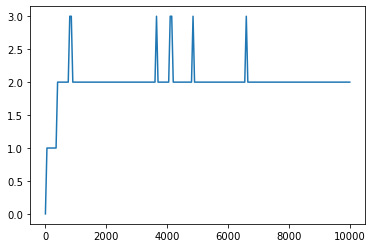

In [7]:
plt.plot(np.array(time._value)*time.unit, traj_inherent_structures)
plt.show()

Podemos calcular la distancia entre configuraciones para hacer un mapa por proximidad: mds o red con threshold.

In [8]:
exploration = oe.exploration_campaign.QuenchAndRestore(explorer)

In [9]:
exploration.run(100, verbose=True)

100%|██████████| 100/100 [03:37<00:00,  2.17s/it]


In [11]:
exploration.pes.n_minima

2

In [10]:
exploration.pes.potential_energy_minima

Quantity(value=[-1245.3386739767693, -1228.710608667818], unit=kilojoule/mole)

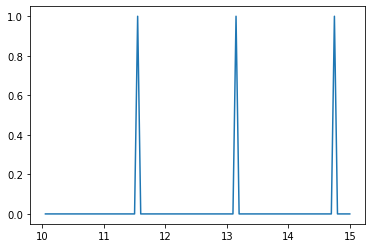

In [13]:
plt.plot(np.array(exploration.time._value)*exploration.time.unit, exploration.trajectory_inherent_structures)
plt.show()